In [100]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.qip.circuit import QubitCircuit, Gate, gate_sequence_product, Measurement, CircuitSimulator

qutip.settings.has_mkl = False  # Fix the OS erros in VSCode

# Gates

## IBM Q Gates

In [101]:
def U3(args):
    theta, phi, lambda_ = args
    matrix = [
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * lambda_ + 1j * phi) * np.cos(theta / 2)],
    ]
    return Qobj(matrix, dims=[[2], [2]])


In [102]:
def U2(args):
    phi, lambda_ = args
    return U3([np.pi/2, phi, lambda_])

In [103]:
def U1(lambda_):
    return U3([0,0,lambda_])

In [104]:
def CU3(args):
    mat = np.zeros((4, 4), dtype=complex)
    mat[0, 0] = mat[1, 1] = 1.0
    mat[2:4, 2:4] = U3(args)

    return Qobj(mat, dims=[[2, 2], [2, 2]])

CU3([1, 0, 0])


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          0.87758256 -0.47942554]
 [ 0.          0.          0.47942554  0.87758256]]

## Unitary Evo

In [105]:
def U(args):
    delta, epsilon, dt = args
    Rz = (1j * delta * sigmaz() * dt).expm()
    Ry = (1j * epsilon * sigmay() * dt / 2).expm()
    return Rz * Ry * Rz

# Circuit

In [106]:
dt = 1

delta = 1
epsilon = 1

# Gamma = 1
# theta = 2*np.arcsin(np.sqrt(Gamma * dt))

theta = 0

In [107]:
qc = QubitCircuit(2, user_gates={"U3": U3, "CU3": CU3, "Uevo": U}, num_cbits=1)

## Unitary Gates

In [108]:
qc.add_gate("Uevo", arg_value=[delta, epsilon, dt])

## Relaxation

In [109]:
def reset(reg, bit, new):
    """Reset the qubit at position bit of reg with dm new"""
    traces = [reg.ptrace(i) for i in range(int(np.log2(reg.shape[0])))]

    traces[bit] = ket2dm(new) if new.type == "ket" else new
    return tensor(traces)


In [110]:
qc.add_gate("CU3", arg_value=[theta, 0, 0])
qc.add_gate("CNOT", targets=[0], controls=[1])
qc.add_measurement("M", [1], classical_store=0)

In [111]:
p = qc.propagators()

# Doesn't include the measurement or reset
D = gate_sequence_product(p)
D

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[-0.36520321+0.79798357j  0.        +0.j          0.47942554+0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.47942554+0.j          0.        +0.j
  -0.36520321-0.79798357j]
 [-0.47942554+0.j          0.        +0.j         -0.36520321-0.79798357j
   0.        +0.j        ]
 [ 0.        +0.j         -0.36520321+0.79798357j  0.        +0.j
   0.47942554+0.j        ]]

# Simulation

In [112]:
iq_state = (
    3 * np.exp(1j * 1) * basis(2, 0) 
    + np.exp(1j * -np.pi) * basis(2, 1)
).unit()
initial_state = tensor(iq_state, basis(2, 0))

b = Bloch3d()
b.add_states(initial_state.ptrace(0))

# sim = CircuitSimulator(qc, mode="density_matrix_simulator")

# final = sim.run(initial_state).get_final_states()[0]
# b.add_states(final.ptrace(0))

# for _ in range(10):
#     final = sim.run(final).get_final_states()[0]
#     b.add_states(final.ptrace(0))


for _ in range(100):
    result = qc.run(state=initial_state)
    reset_result = reset(result, 1, basis(2,0))

    b.add_states(reset_result.ptrace(0))

    initial_state = reset_result

b.show()


(<matplotlib.contour.QuadContourSet at 0x20d7cf989a0>,
 <AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>)

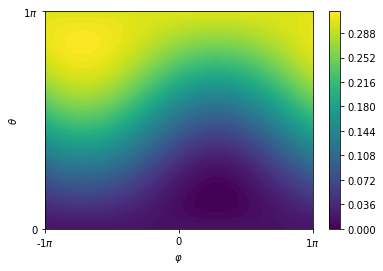

In [113]:
from sync_calcs import spin_husimi_qfunc
from sync_plots import plot_spin_qfunc

# Plotting constants
n = 50  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector

Q = spin_husimi_qfunc(initial_state.ptrace(0), theta, phi, method="qutip")
plot_spin_qfunc(Q.T, phi, theta)